
<div dir='rtl'>
<h2>
دریافت دیتاست
    </h2>
</div>
<hr/>

<div dir='rtl'>
    در ابتدا،‌عکس های دیتاست را که در google drive آپلود شده است را با استفاده از wget بارگزاری کرده و آنها را unzip میکنیم.
</div>


In [ ]:
# download ORL dataset
!mkdir ORL && cd ORL && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WwN1wqLxuXAoJnrAP53yAeoJtUI4nl43' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WwN1wqLxuXAoJnrAP53yAeoJtUI4nl43" -O ORL.zip && rm -rf /tmp/cookies.txt && unzip ORL


<div dir='rtl'>
<h2>
تبدیل دیتاست
    </h2>
</div>
<hr/>

<br>
<div dir='rtl'>
در گام بعد باید عکس ها به فرمتی تبدیل کنیم که بتوان روی آنها پردازش انجام داد. برای همین بعد از لود کردن عکس، آنرا در یک numpy array ذخیره میکنیم و با استفاده از flatten آنرا تبدیل به یک vector میکنیم و به این صورت عکسمان که قبلا 70×80 بود، به برداری با 5600 درایه تبدیل میشود.
از آنجایی که عکس های مربوط به شخص ۴۱ gray scale نبودند، یک تبدیل به gray scale هم باید انجام بدهیم که با استفاده از عبارت <code>convert('L')</code> انجام میشود.
</div>

In [ ]:
from PIL import Image
import numpy as np

total_subjects=41
each_person_images=10
image_list=[]
for i in range(total_subjects):
    for j in range (1, each_person_images+1):
        image='/content/ORL/' + str(i*10+j) + '_' + str(i+1) + '.jpg'
        image_list.append(np.asarray(Image.open(image).convert('L')).flatten())

data=np.asarray(image_list)
data[0:10]


array([[36, 44, 37, ..., 38, 41, 35],
       [46, 56, 45, ..., 28, 31, 24],
       [28, 40, 42, ..., 24, 28, 20],
       ...,
       [31, 37, 27, ..., 32, 41, 28],
       [30, 38, 41, ..., 35, 39, 31],
       [21, 33, 30, ..., 29, 34, 26]], dtype=uint8)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')


<div dir='rtl'>
<h2>
پردازش اولیه روی داده ها
    </h2>
</div>
<hr/>

<br>
<div dir='rtl'>

در این گام میخواهیم با استفاده از روش PCA(Principle Component Analysis) یک بازنمایی از داده ها به دست بیاوریم.
در واقع PCA برای dimentionality reduction استفاده میشود که میتواند دو کاربرد برای ما داشته باشد.


1.   Data Compression: میتوانیم اگر feature space بزرگی داریم، آنرا کاهش بدهیم و به یک بازنمایی از مقادیر ویژه بزرگتر ماتریس برسیم که کار پردازش را برای ما آسان تر میکند.

2.   Visualization: وقتی feature space بزرگی داریم، plot کردن تقریبا غیر ممکن میشود پس اگر dimention را به ۲ یا ۳ تغییر دهیم میتوانیم داده ها را در صفحه ای ۲ بعدی یا ۳ بعدی plot کنیم و به درک بهتری از عملکرد الگوریتم های خپشه بندی برسیم.
</div>

<div dir='rtl'>
اساس کار الگوریتم PCA، تجزیه مقادیر یکه(Singular Value Decomposition) میباشد. و چون قطر اصلی Sigma که تابع svd به ما میدهد، سورت شده است و ابتدا مقادیر ویژه بزرگتر روی آن هستند، میتوانیم با در نظر گرفتن r مقدار ویژه اول به بازنمایی خوبی از داده اولیه برسیم.
</div>

<div dir='rtl'>
قبل از اجرای الگوریتم PCA، داده ها با استفاده از mean normalization، نرمال میکنیم و نرمال شده را به الگوریتم PCA میدهیم.
</div>

<div dir='rtl'>
الگوریتم PCA را دوبار اجرا میکنیم یکبار با r=2 برای visualize کردن داده ها و یکبار با r=100 برای بازنمایی که الگوریتم های خوشه بندی را روی آن انجام دهیم.
</div>

In [ ]:
def pca(data, number_of_components):
    sigma = (1/data.shape[0])*(np.dot(data.T, data))
    u, s, v = np.linalg.svd(sigma)
    u_r = u[:,0:number_of_components]
    return data.dot(u_r)


normalized_data = (data - data.mean())/ (data.max() - data.min())
reduced_data = pca(normalized_data, 2)

In [ ]:
reduced_data_f100 = pca(normalized_data, 100)



<div dir='rtl'>
<h2>
پیاده سازی Round Index
    </h2>
</div>
<hr/>

<div dir='rtl'>
قبل از پیاده سازی الگوریتم های خوشه بندی، ابتدا Round Index را پیاده سازی میکنیم که برای evaluation خوشه بندی میتوانیم از آن استفاده کنیم.
در این روش pair ها را باید با یکدیگر مقایسه کنیم و میتوان آنها را به ۴ دسته تقسیم کرد.
</div>
<div dir='rtl'>

1. True Positive (TP): دو داده مشابه در یک خوشه قرار گرفته باشند.
2. True Negetive (TN): دو داده غیر مشابه در کلاستر های متفاوت باشند.
3. False Positive (FP): دو داده غیر مشابه در یک کلاستر قرار گرفته باشند.
4. False Negetive (FN): دو داده مشابه در کلاستر های متفاوت قرار گرفته باشند.

</div>
<div dir='rtl'>
میتوانیم Round Index را با استفاده از فرمول زیر محاسبه کنیم.
$$$$
$$$$
</div>
<div dir='rtl'>
$$ RI = {{TP + TN} \over {TP+TN+FN+FP}}$$
</div>
<div dir='rtl'>
$$$$
$$$$
برای به دست آوردن محموع TP و FP میتوانیم ترکیب های ۲ تایی در هر کلاستر را حساب کنیم. سپس میتوانیم با محاسبه ترکیب های دوتایی داده های مشابه در یک کلاستر، مقدار TP را حساب کنیم و در نتیجه با کم کردن مقدار TP از مجموع FP و TP میتوانیم FP را نیز محاسبه کنیم.
</div>
<div dir='rtl'>
در کد زیر، از آنجایی که میدانیم داده ها به ترتیب خوانده شده اند و هر ۱۰ داده یک لیبل دارند، برای محاسبه TP ۱۰ تا ۱۰ تا لیبل های الگوریتم خوشه بندی را نگاه میکنیم که یعنی این ۱۰ تایی که انتخاب میشوند در واقعیت یک لیبل دارند. و سپس خروجی ها خوشه بندی را در آن ۱۰ داده چک میکنیم و تعداد لیبل ها را میشماریم. اگر لیبلی از ۲ بیشتر شد شمارشش، یعنی باید در ترکیب های ۲ تایی برای TP آنرا محاسبه کنیم و به این صورت مقدار TP را به دست می آوریم.
</div>

<div dir='rtl'>
برای محاسبه FN هم میتوانیم از TP استفاده کنیم و کل ترکیب های دوتایی را برای تمامی کلاس های باید محاسبه کنیم و مقدار TP را  از آن کم کنیم.
از آنجایی که کلاس هایمان ۱۰ تایی هستند محسابه FP در اینجا بسیار ساده است.
</div>

In [ ]:
from collections import Counter

def round_index(clustering_labels):
    FP_TP = 0
    TP = 0
    for index in range(-1, clustering_labels.max()):
        count = np.count_nonzero(clustering_labels == index)
        FP_TP += (count * (count-1))/2
    for index in range(total_subjects):
        counter = Counter(clustering_labels[index*10:(index+1)*10])
        x = [freq for val, freq in counter.items() if (freq >= 2 and val > -1)]
        for number in x:
            TP += (number * (number-1))/2
    FP = FP_TP - TP
    n = (len(clustering_labels) * (len(clustering_labels)-1))/2

    FN = (total_subjects*((each_person_images * (each_person_images-1))/2))-TP
    TN = n - (FN+FP+TP)

    return (TP+TN)/n


<div dir='rtl'>
<h2>
پیاده سازی الگوریتم K-Means
</h2>
</div>
<hr/>

<div dir='rtl'>
برای پیاده سازی الگوریتم های clustering از کتابخانه SciKit استفاده میکنیم.
برای پیاده سازی الگوریتم k-means ابتدا یک model برای الگوریتم k-means میسازیم و k را که درواقع تعداد کل افرادی است که میخواهیم خوشه بندی شود را که در اینجا ۴۱ است به مدل میدهیم و سپس دیتایی که توسط PCA آماده کردیم برای خوشه بندی را به مدل k-means میدهیم.
</div>

<div dir='rtl'>
بعد از اتمام اجرای الگوریتم، label هایی را که مدل به ما میدهد را به تابع Round Index میدهیم تا عددی برای میزان خوب بودن الگوریتم به ما بدهد.
هر چه این عدد به ۱ نزدیکتر باشد یعنی الگوریتم عملکرد بهتری دارد.
</div>
<div dir='rtl'>
در اینجا Round Index عدد 0.98 به ما میدهد که به نظر عدد مورد قبولی برای خوشه بندی است.
</div>

In [ ]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=total_subjects, random_state=42)
kmeans_model.fit(reduced_data_f100)

print('K-means RI: ', round_index(kmeans_model.labels_))

K-means RI:  0.9815492873755144


<div dir='rtl'>
<h2>
نمایش K-Means
</h2>
</div>
<hr/>

<div dir='rtl'>
برای نمایش و plot کردن میتوانیم از داده های کاهش یافته با r=2 در الگوریتم PCA استفاده کنیم. الگوریتم PCA با تعداد component ۲ بهترین تقریب از ویژگی ها را در ۲ مقدار برای ما خلاصه میکند که میتوانیم با استفاده از آن، خروجی خوشه بندی را plot کنیم و درک بهتری از عملکرد خوشه بندی داشته باشیم.
</div>

In [ ]:
def plot_2d(labels, title):
    df=pd.DataFrame(reduced_data)
    df.columns=['feature1', 'feature2']

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='feature1', y='feature2', data=df, s=30,
                    hue=labels,
                    palette='GnBu_d').set(title=title)
    plt.tight_layout()
    plt

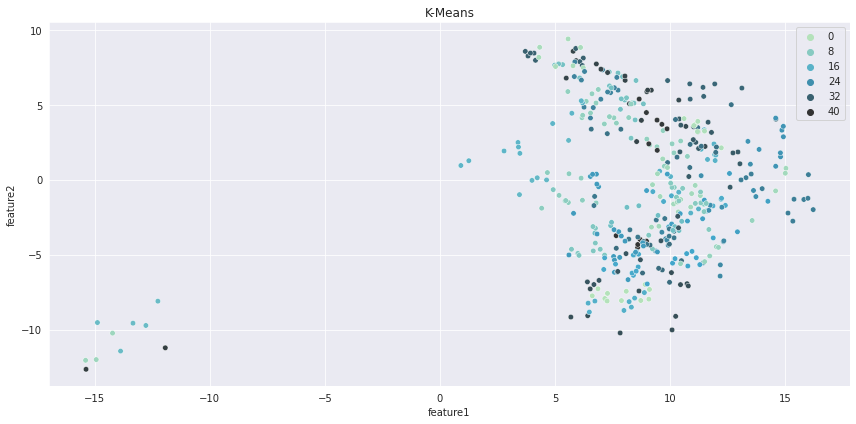

In [ ]:
plot_2d(kmeans_model.labels_, 'K-Means')

<div dir='rtl'>
<h2>
نمایش کلاستر ها
</h2>
</div>
<hr/>

<div dir='rtl'>
در ادامه ۲ کلاستر  را باعکس هایشان نمایش میدهیم در کلاستر اول عکس ها به درستی در یک کلاستر قرار گرفته اند و در کلاستر دوم هم تاحدی درست است ولی چند تا عکس اشتباه هم قرار گرفته است ولی باز هم عکس ها به هم شباهت هایی دارند.
</div>

In [ ]:
def plot_cluster(cluster_number, labels):
    image_list=[]

    for index , value in enumerate(labels):
        if value == cluster_number:
            image_list.append(Image.fromarray(data[index].reshape(80, 70)))

    _, axs = plt.subplots(2, 5, figsize=(12, 6))
    axs = axs.flatten()
    for img, ax in zip(image_list, axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img, cmap='gray')
    plt


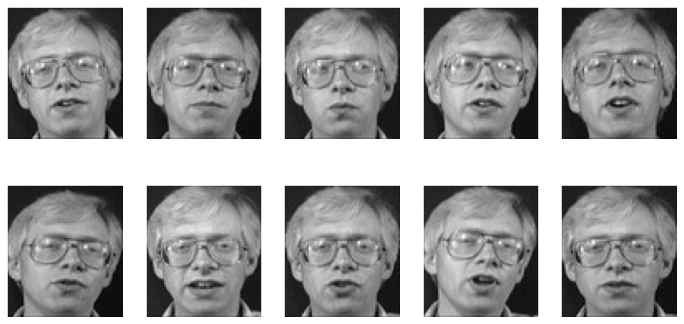

In [ ]:
plot_cluster(3, kmeans_model.labels_)

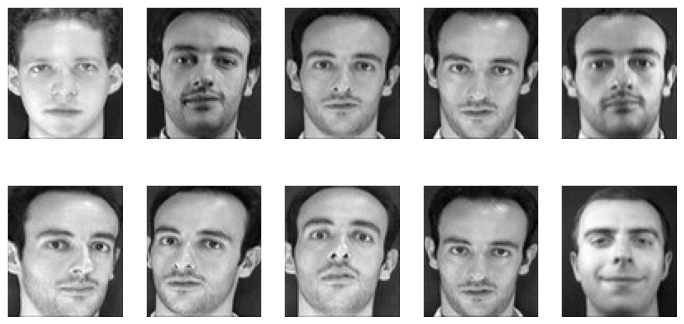

In [ ]:
plot_cluster(21, kmeans_model.labels_)

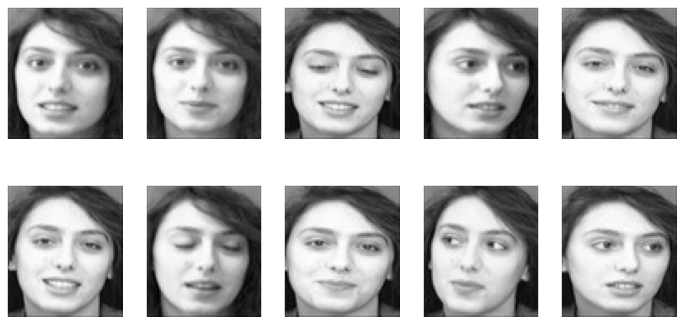

In [ ]:
plot_cluster(27, kmeans_model.labels_)


<div dir='rtl'>
<h2>
پیاده سازی الگوریتم های Agglomerative
</h2>
</div>
<hr/>

<div dir='rtl'>
برای این بخش نیز همانند الگوریتم k-means عمل میکنیم.
مشاهده میشود که الگوریتم Single Link در مقایسه با الگوریتم های Complete Link و Average ضعیف تر عمل میکند.
</div>



In [ ]:
from sklearn.cluster import AgglomerativeClustering
complete_agglomerative_model = AgglomerativeClustering(n_clusters=total_subjects, linkage = 'complete')
complete_agglomerative_model.fit(reduced_data_f100)

print('Complete Link RI: ', round_index(complete_agglomerative_model.labels_))

single_agglomerative_model = AgglomerativeClustering(n_clusters=total_subjects, linkage = 'single')
single_agglomerative_model.fit(reduced_data_f100)

print('Single Link RI: ', round_index(single_agglomerative_model.labels_))

average_agglomerative_model = AgglomerativeClustering(n_clusters=total_subjects, linkage = 'average')
average_agglomerative_model.fit(reduced_data_f100)

print('Average RI: ', round_index(average_agglomerative_model.labels_))


Complete Link RI:  0.9753235136263343
Single Link RI:  0.6226131552269067
Average RI:  0.9572186773212475


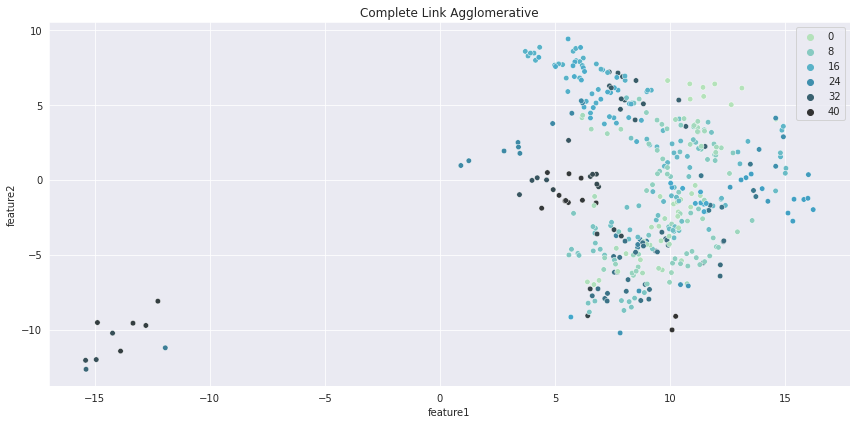

In [ ]:
plot_2d(complete_agglomerative_model.labels_, 'Complete Link Agglomerative')

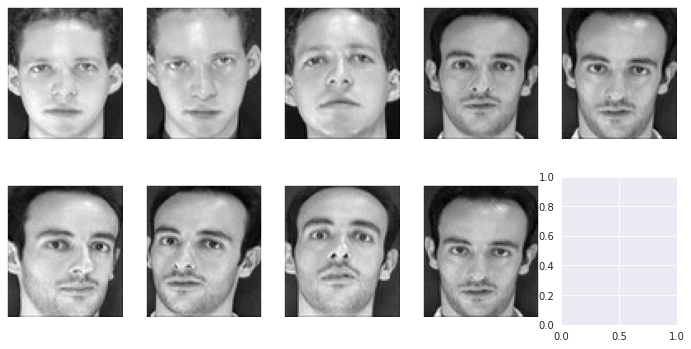

In [ ]:
plot_cluster(4, complete_agglomerative_model.labels_)

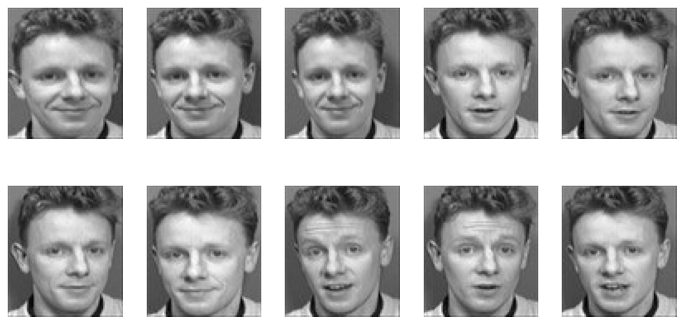

In [ ]:
plot_cluster(17, complete_agglomerative_model.labels_)

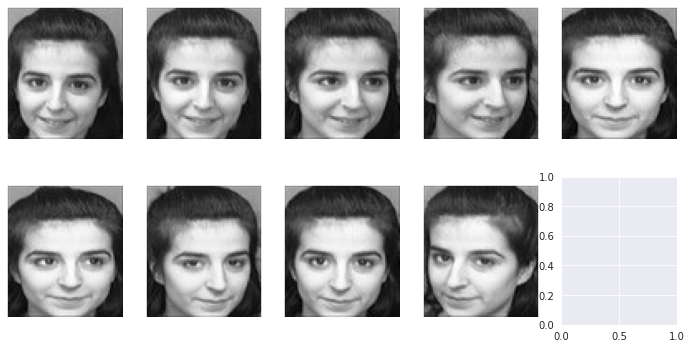

In [ ]:
plot_cluster(0, complete_agglomerative_model.labels_)

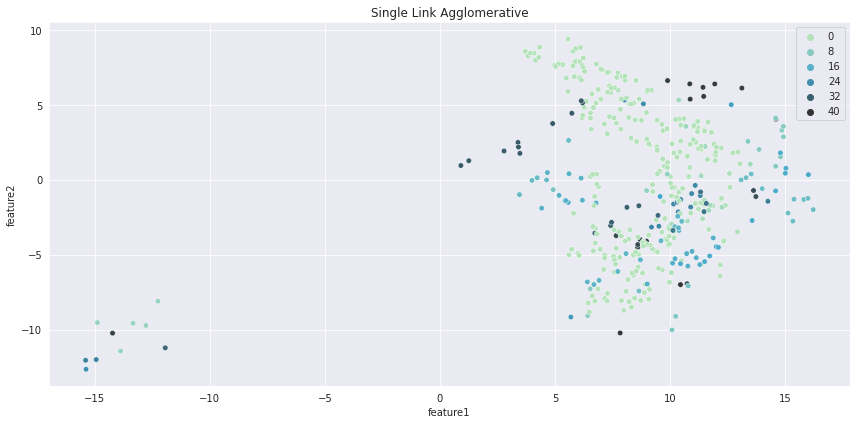

In [ ]:
plot_2d(single_agglomerative_model.labels_, 'Single Link Agglomerative')

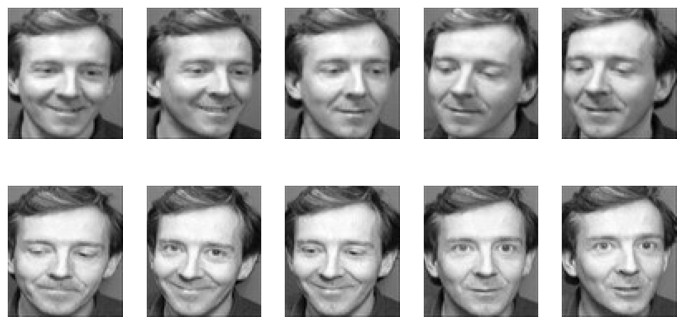

In [ ]:
plot_cluster(0, single_agglomerative_model.labels_)

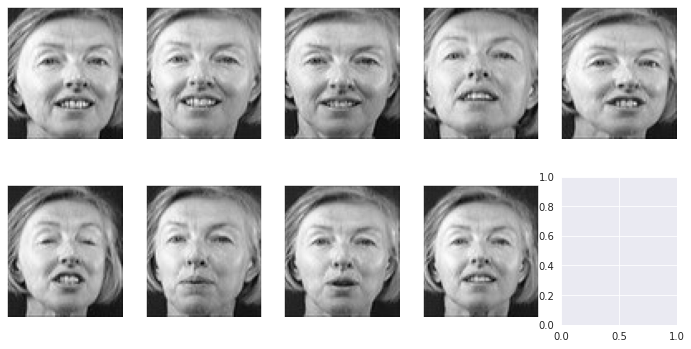

In [ ]:
plot_cluster(15, single_agglomerative_model.labels_)

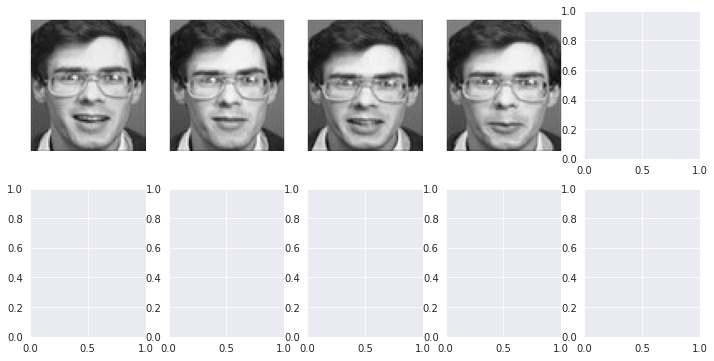

In [ ]:
plot_cluster(4, single_agglomerative_model.labels_)

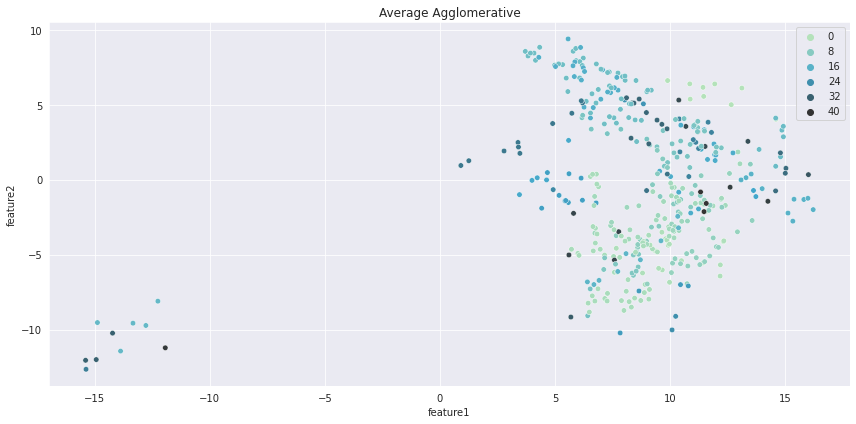

In [ ]:
plot_2d(average_agglomerative_model.labels_, 'Average Agglomerative')

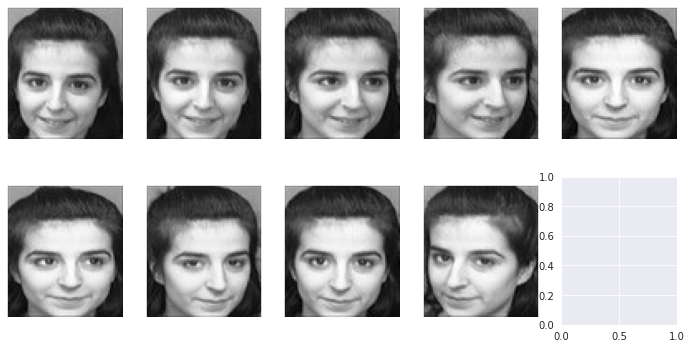

In [ ]:
plot_cluster(0, average_agglomerative_model.labels_)

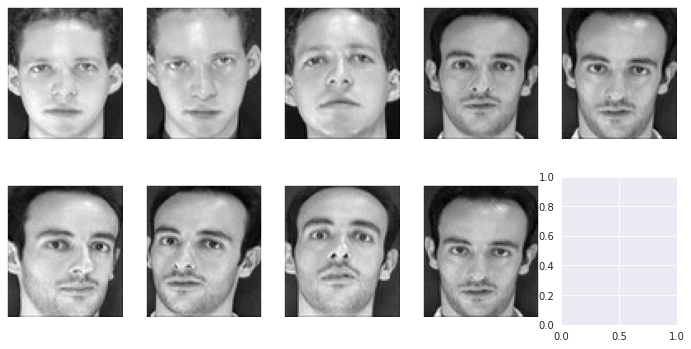

In [ ]:
plot_cluster(5, average_agglomerative_model.labels_)

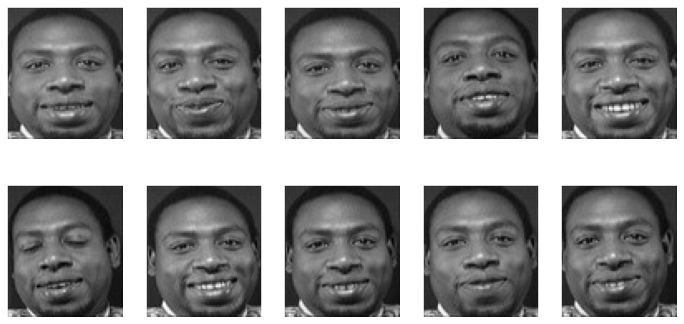

In [ ]:
plot_cluster(17, average_agglomerative_model.labels_)


<div dir='rtl'>
<h2>
پیاده سازی الگوریتم DBSCAN
</h2>
</div>
<hr/>

<div dir='rtl'>
در این الگوریتم مشاهده میکنیم که عکس های مربوط به یک کلاس ممکن است در چندین کلاستر قرار گرفته باشند و تعداد کلاستر هایمان بیشتر است چون مقدار k را برای الگوریتم مشخص نکردیم و برای همین تعداد را بیشتر در نظر میگیریم تا دقت بالانری داشته باشیم.
همانظور که در RI هم مشخص است این الگوریتم کارایی خوبی دارد ولی برای این مثال چون تراکم ها متفاوتند به خوبی ممکن است عمل نکند و داده های زیادی را نویز تشخیص دهد. برای همین در ادامه به ارتقا و بهبود این الگوریتم میپردازیم.
</div>


In [ ]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=7.2, min_samples=3)
dbscan_model.fit(reduced_data_f100)

print('DBSCAN RI: ', round_index(dbscan_model.labels_))


DBSCAN RI:  0.9409386367702308


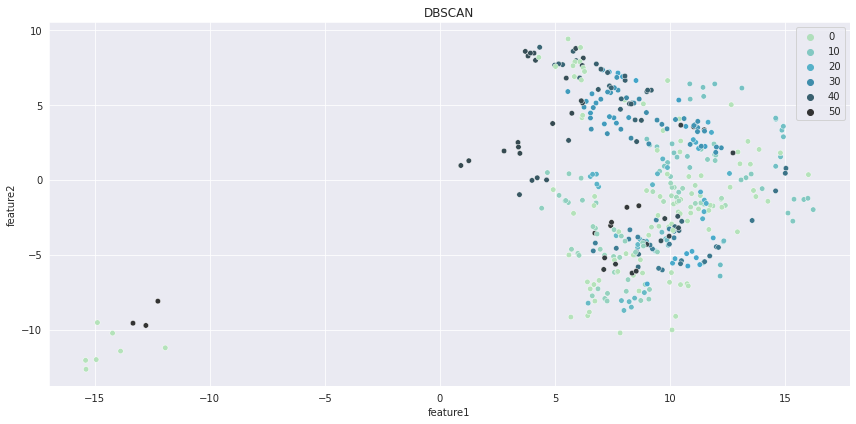

In [ ]:
plot_2d(dbscan_model.labels_, 'DBSCAN')

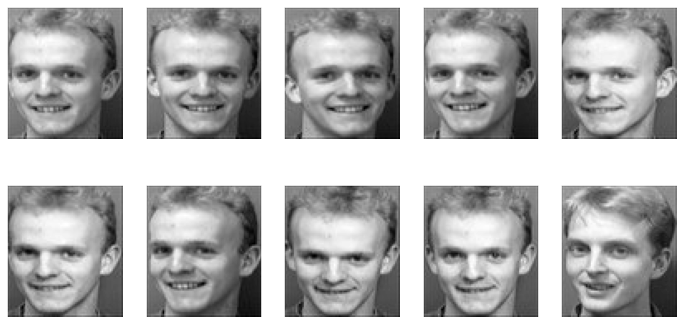

In [ ]:
plot_cluster(5, dbscan_model.labels_)

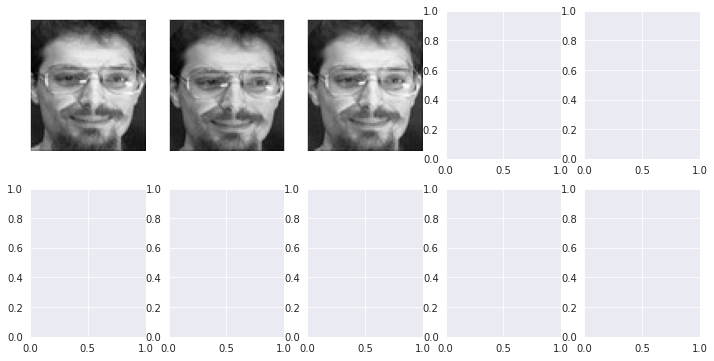

In [ ]:
plot_cluster(21, dbscan_model.labels_)

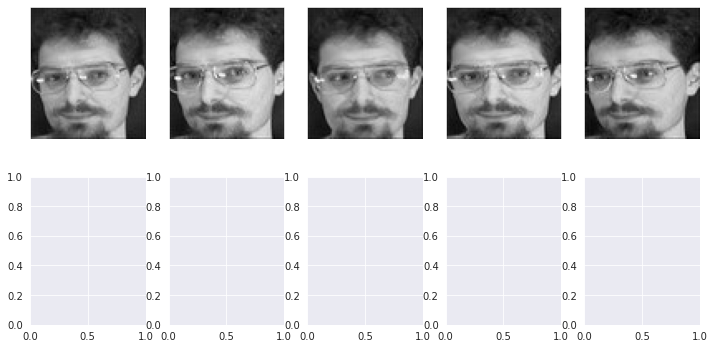

In [ ]:
plot_cluster(22, dbscan_model.labels_)


<div dir='rtl'>
<h2>
ارتقاء DBSCAN
</h2>
</div>
<hr/>

<div dir='rtl'>
از آن جایی که داده های نویز زیادی در این الگوریتم تشخیص داده شده است، میتوانیم با ترکیب k-means برای داده های نویز، این الگوریتم را ارتقا دهیم.
همانطور که میدانیم در این مسئله و دیتاست، داده نویز نداریم و برای هر شخص دقیقا ۱۰ تصویر داریم برای همین تشخیص نویز توسط الگوریتم، مقدار Round Index را پایین می آورد.
</div>

<div dir='rtl'>
در زیر الگوریتمی ارائه شده که در ابتدا داده های نویز را بر اساس الگوریتم k-means خوشه بندی میکند و در ادامه به merge کردن کلاستر های مشابه که دارای دیتا های کمی هستند میپردازد چون میدانیم داده های یک کلاس در چندین کلاستر قرار گرفته اند و ترکیب کردن این کلاستر های کوچک از داده ها میتواند به افزایش کارایی الگوریتم کمک کند.
</div>
<div dir='rtl'>
همانطور که مشاهده میشود، مقدار Round Index از عدد 0.94 در الگوریتم اولیه به 0.985 افزایش پیدا کرده است که ارتقا نسبتا خوبی در این بازه میباشد.
</div>

In [ ]:
import math


def merge_small_clusters(min_cluster_size, labels, data):
    clusters_to_remove=[]
    counter = Counter(labels)
    for key, value in counter.items():
        if value <= min_cluster_size:
            clusters_to_remove.append(key)

    clusters_to_remove
    for index, value in enumerate(labels):
        if value in clusters_to_remove:
            min_d = math.inf
            min_cluster = value
            for i, v in enumerate(labels):
                if i != index:
                    d= np.linalg.norm(data[index]-data[i])
                    if d < min_d and counter[v] > min_cluster_size+2:
                        min_d = d
                        min_cluster = v

            labels[index] = min_cluster
    return labels


max = dbscan_model.labels_.max()

for index, value in enumerate(dbscan_model.labels_.copy()):
    if value == -1:
        dbscan_model.labels_[index] += max + kmeans_model.labels_[index] + 1

labels=dbscan_model.labels_


labels = merge_small_clusters(2, labels, data)


In [ ]:
print('DBSCAN RI: ', round_index(dbscan_model.labels_))


DBSCAN RI:  0.9853897071978055


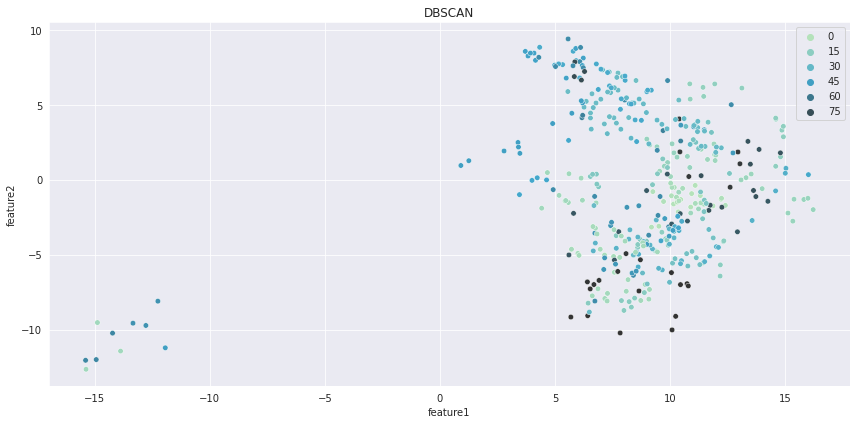

In [ ]:
plot_2d(labels, 'DBSCAN')

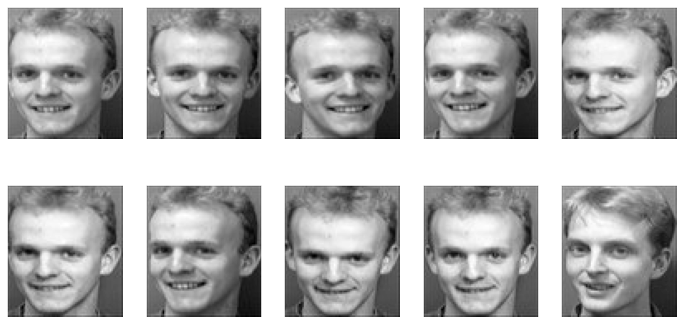

In [ ]:
plot_cluster(5, labels)

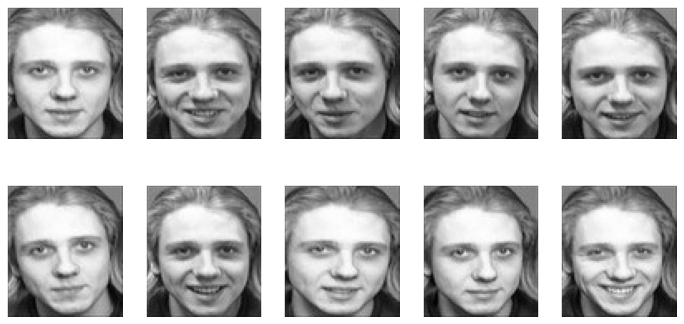

In [ ]:
plot_cluster(15, labels)

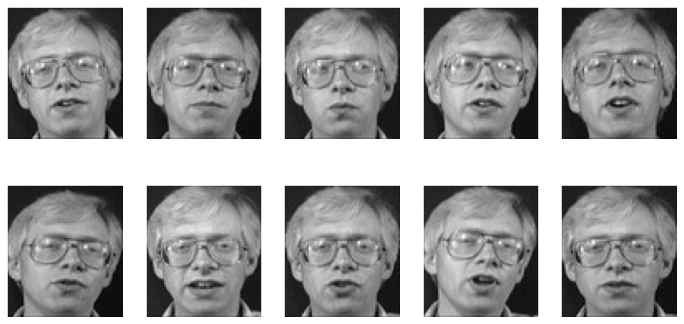

In [ ]:
plot_cluster(0, labels)